# Import Modules

In [15]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import (
    VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0,
    vgg16, resnet50, mobilenet, inception_v3, efficientnet
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import sys
print("Python:", sys.version)
print("TensorFlow:", tf.__version__)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow: 2.19.0


In [3]:
# Set Global Random Seeds
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# # Paths

In [4]:
from google.colab import drive
drive.mount("/drive")

Mounted at /drive


In [5]:
ROOT = Path("/drive/MyDrive/Multiclass_Fish_Image_Classification")
DATA_ROOT = ROOT / "Dataset"

In [6]:
ARTIFACTS = ROOT / "artifacts"
ARTIFACTS.mkdir(parents=True, exist_ok=True)

In [7]:
train_dir = DATA_ROOT / "train"
val_dir   = DATA_ROOT / "val"
test_dir  = DATA_ROOT / "test"

# Common Parameters

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_TL = 5      # transfer learning
EPOCHS_FT = 10     # fine-tuning

# Load Datasets

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)

Found 6225 files belonging to 11 classes.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, shuffle=False
)

Found 1092 files belonging to 11 classes.


In [11]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, shuffle=False
)

Found 3187 files belonging to 11 classes.


In [12]:
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

print("Classes:", class_names)

Classes: ['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']


In [13]:
with open(ARTIFACTS / "class_indices.json", "w") as f:
    json.dump({i: c for i, c in enumerate(class_names)}, f, indent=2)

print("Saved:", ARTIFACTS / "class_indices.json")

Saved: /drive/MyDrive/Multiclass_Fish_Image_Classification/artifacts/class_indices.json


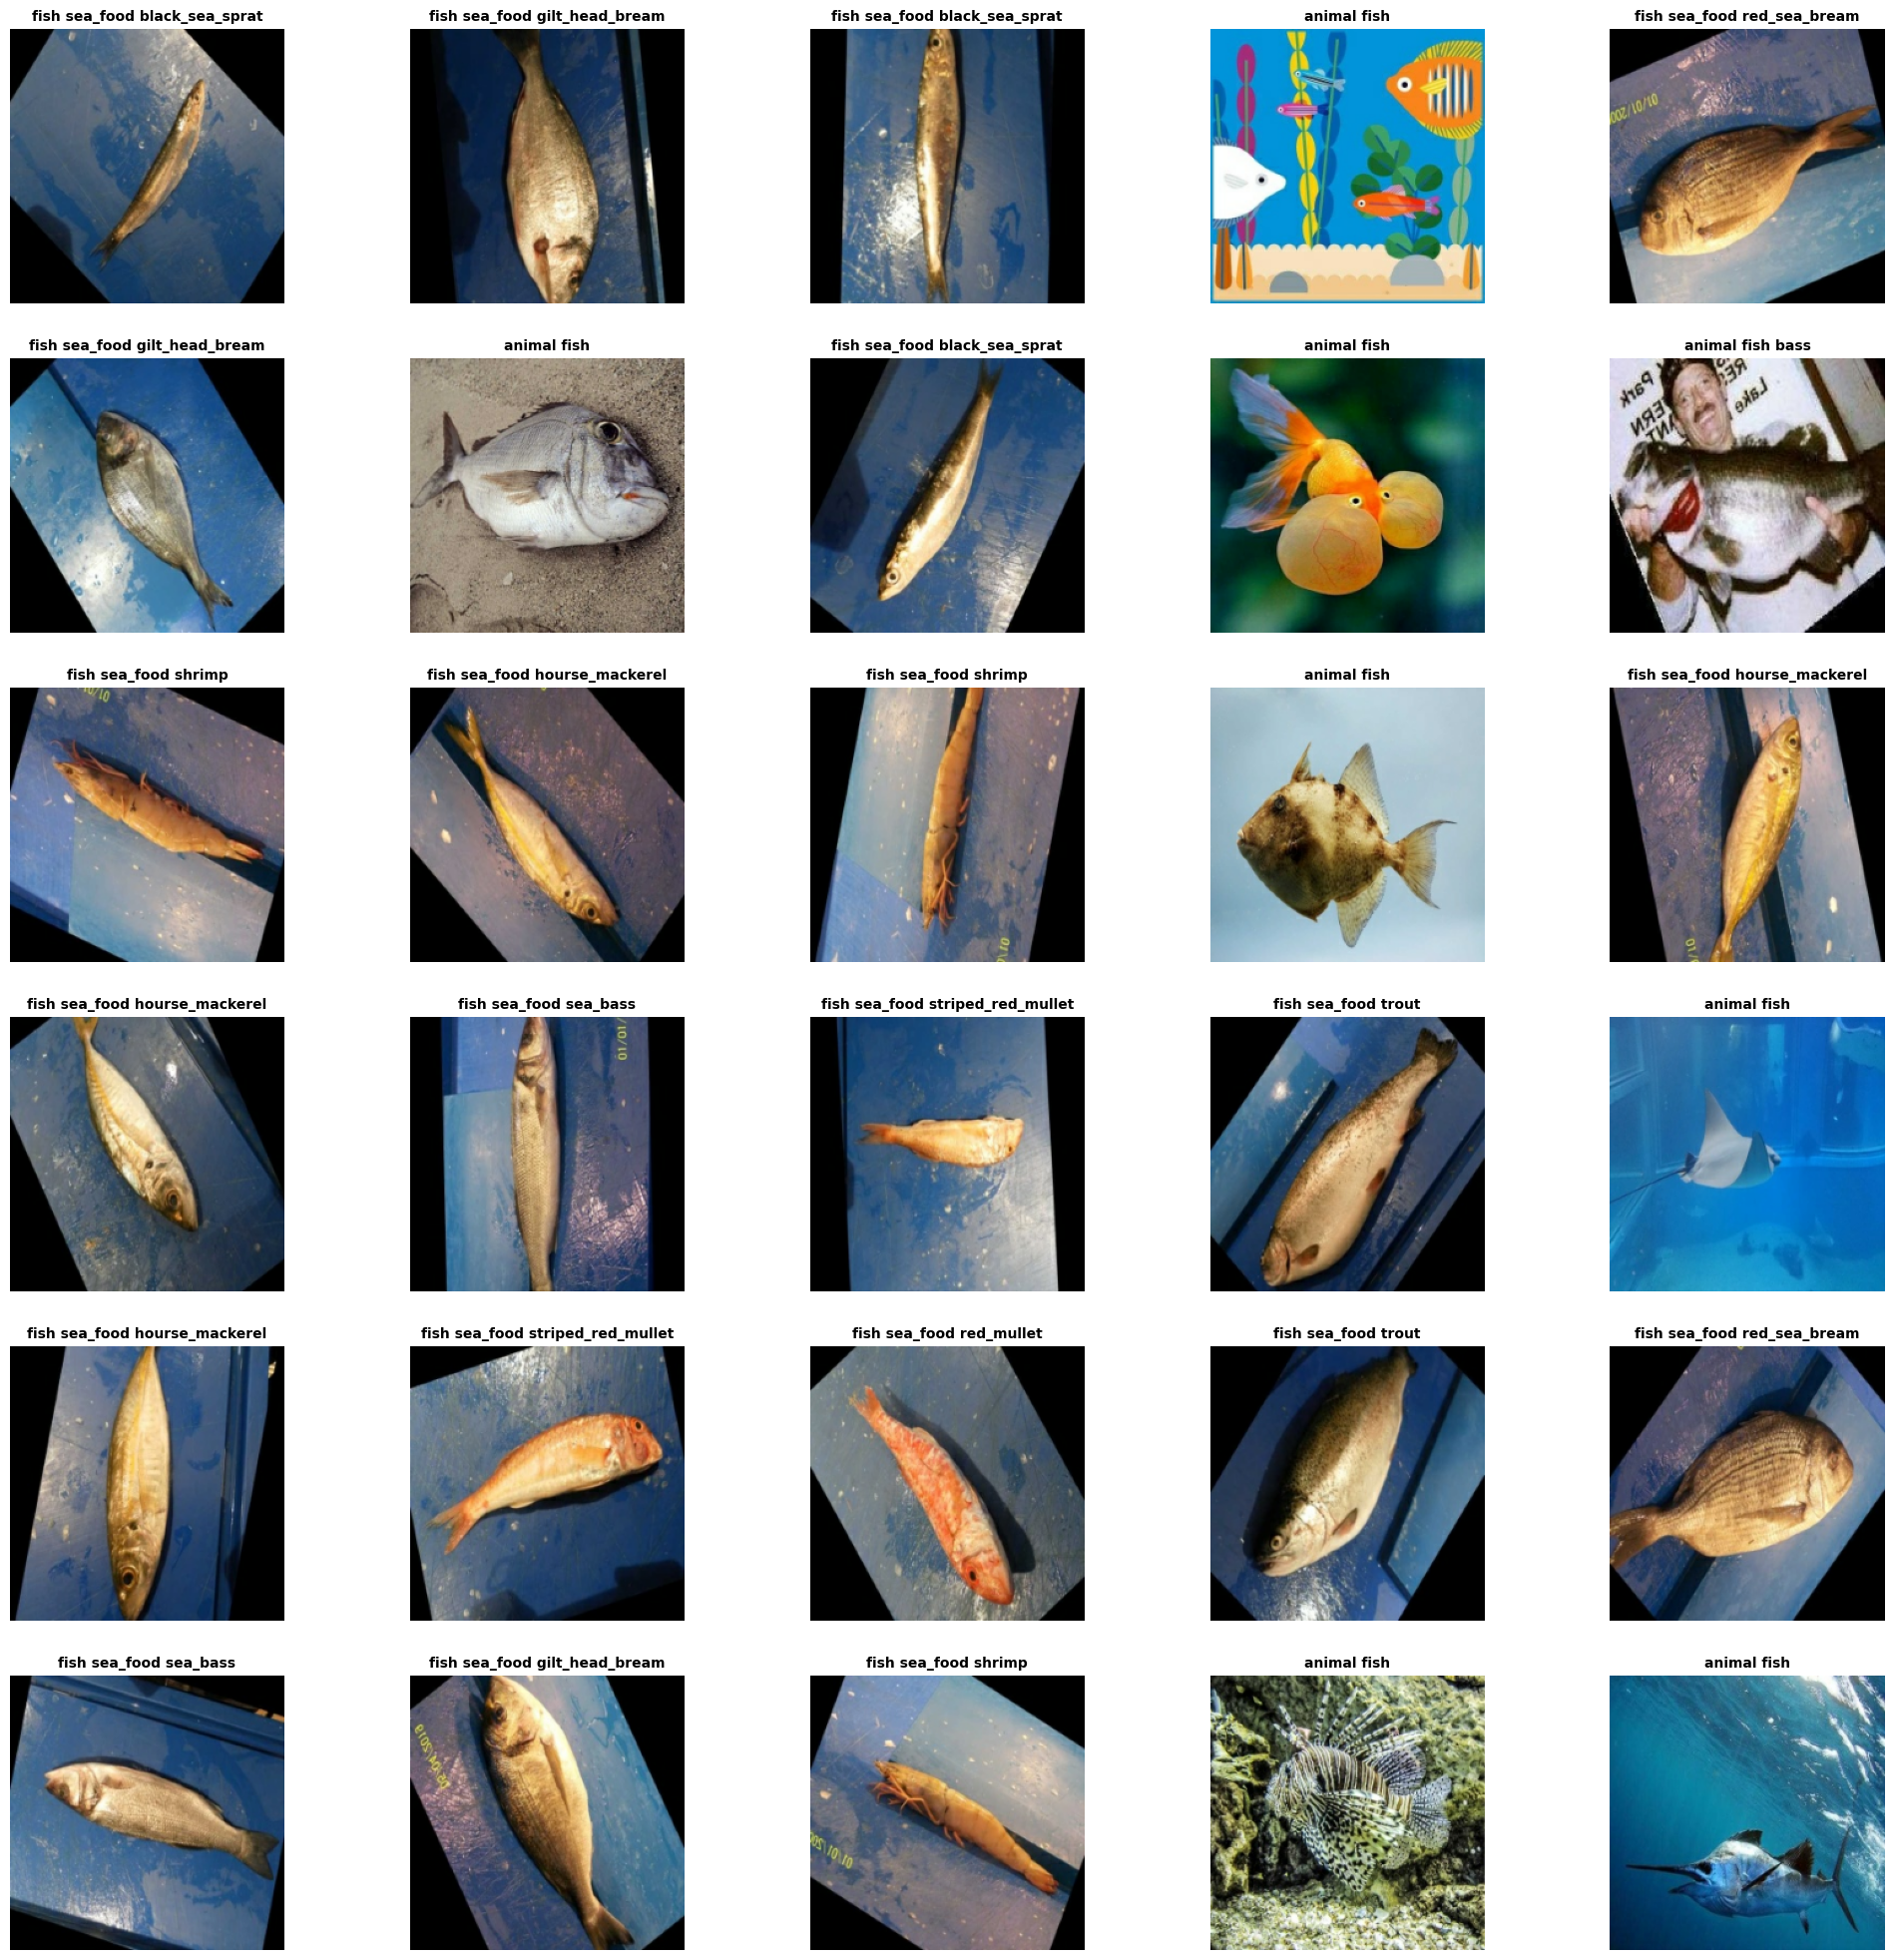

In [16]:
plt.figure(figsize=(25,25))
for i in train_ds.take(1):
  for j in range(30):
    plt.subplot(6,5,j+1)
    plt.imshow(i[0][j].numpy().astype("uint8"))
    plt.title(class_names[i[1][j]], fontsize=10, fontweight='bold')
    plt.axis("off")
plt.show()

# Data Augmentation (TRAINING ONLY)

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Preprocess function mapping

In [18]:
preprocess_map = {
    "VGG16": vgg16.preprocess_input,
    "ResNet50": resnet50.preprocess_input,
    "MobileNet": mobilenet.preprocess_input,
    "InceptionV3": inception_v3.preprocess_input,
    "EfficientNetB0": efficientnet.preprocess_input
}

# Dataset Pipeline

In [19]:
def prepare_ds(ds, model_name, training=False):
    if training:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    ds = ds.map(
        lambda x, y: (preprocess_map[model_name](x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return ds.prefetch(tf.data.AUTOTUNE)

# Custom CNN Preprocessing

In [20]:
def prepare_custom_ds(ds, training=False):
    if training:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    ds = ds.map(lambda x, y: (x / 255.0, y))
    return ds.prefetch(tf.data.AUTOTUNE)

# Custom CNN Model

In [21]:
def build_custom_cnn(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs / 255.0

    x = layers.Conv2D(32, 5, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="CustomCNN")
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Train Custom CNN

In [24]:
histories = {}

print("Training Custom CNN")

train_pp = prepare_custom_ds(train_ds, training=True)
val_pp   = prepare_custom_ds(val_ds)

custom_model = build_custom_cnn(NUM_CLASSES)

history_custom = custom_model.fit(
    train_pp,
    validation_data=val_pp,
    epochs=15,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            ARTIFACTS / "CustomCNN.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        )
    ]
)

histories["Custom_CNN"] = history_custom.history

Training Custom CNN
Epoch 1/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1388 - loss: 2.3541
Epoch 1: val_accuracy improved from -inf to 0.17125, saving model to /drive/MyDrive/Multiclass_Fish_Image_Classification/artifacts/CustomCNN.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 1079s 6s/step - accuracy: 0.1389 - loss: 2.3540 - val_accuracy: 0.1712 - val_loss: 2.2455
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.2112 - loss: 2.1650
Epoch 2: val_accuracy improved from 0.17125 to 0.33425, saving model to /drive/MyDrive/Multiclass_Fish_Image_Classification/artifacts/CustomCNN.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 402ms/step - accuracy: 0.2113 - loss: 2.1646 - val_accuracy: 0.3342 - val_loss: 1.9227
Epoch 3/15
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.2920 - loss: 1.9342
Epoch 3: val_accuracy improved from 0.33425 to 0.38187, saving model to /drive/MyDrive/Multiclass_Fish_Image_Classification/artifacts/CustomCNN.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 85s 

In [25]:
with open(ARTIFACTS / "custom_cnn_histories.json", "w") as f:
    json.dump(histories, f, indent=4)

print("Saved: custom_cnn_histories.json")

Saved: custom_cnn_histories.json


# Transfer-Learning Model Builder

In [26]:
def build_transfer_model(base_model, num_classes):
    base_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Pretrained Model Callbacks

In [32]:
def callbacks_tl(name):
    return [
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint(ARTIFACTS / f"{name}.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
    ]

def callbacks_ft(name):
    return [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
        EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1),
        ModelCheckpoint(ARTIFACTS / f"{name}.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
    ]

# Pretrained Models Dictionary

In [28]:
pretrained_models = {
    "VGG16": VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    "ResNet50": ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    "MobileNet": MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    "InceptionV3": InceptionV3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    "EfficientNetB0": EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
}

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train Pre-trained Models + Fine-Tuning

In [33]:
histories = {}

for name, base_model in pretrained_models.items():
    print(f"\nTraining {name}")

    train_pp = prepare_ds(train_ds, name, training=True)
    val_pp   = prepare_ds(val_ds, name)

    model = build_transfer_model(base_model, NUM_CLASSES)

    # ----- Transfer Learning -----
    history_tl = model.fit(
        train_pp,
        validation_data=val_pp,
        epochs=EPOCHS_TL,
        callbacks=callbacks_tl(name)
    )

    # ----- Fine Tuning -----
    base_model.trainable = True
    unfreeze_ratio = 0.3
    unfreeze_layers = int(len(base_model.layers) * unfreeze_ratio)

    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history_ft = model.fit(
        train_pp,
        validation_data=val_pp,
        epochs=EPOCHS_FT,
        callbacks=callbacks_ft(name)
    )

    histories[name] = {
        "transfer_learning": history_tl.history,
        "fine_tuning": history_ft.history
    }


Training VGG16
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.6630 - loss: 2.0626
Epoch 1: val_accuracy improved from -inf to 0.97344, saving model to /drive/MyDrive/Multiclass_Fish_Image_Classification/artifacts/VGG16.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 469ms/step - accuracy: 0.6638 - loss: 2.0561 - val_accuracy: 0.9734 - val_loss: 0.0963
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9543 - loss: 0.1462
Epoch 2: val_accuracy improved from 0.97344 to 0.98901, saving model to /drive/MyDrive/Multiclass_Fish_Image_Classification/artifacts/VGG16.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 486ms/step - accuracy: 0.9543 - loss: 0.1461 - val_accuracy: 0.9890 - val_loss: 0.0467
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9753 - loss: 0.0764
Epoch 3: val_accuracy improved from 0.98901 to 0.99176, saving model to /drive/MyDrive/Multiclass_Fish_Image_Classification/artifacts/VGG16.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 102s 521ms/step - a

In [34]:
with open(ARTIFACTS / "pretrained_model_histories.json", "w") as f:
    json.dump(histories, f, indent=4)

print("Saved: pretrained_model_histories.json")

Saved: pretrained_model_histories.json


# Plot Training History (Accuracy & Loss)

In [35]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Train")
    plt.plot(history["val_accuracy"], label="Validation")
    plt.title(f"{title} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Validation")
    plt.title(f"{title} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [36]:
with open(ARTIFACTS / "custom_cnn_histories.json", "r") as f:
    custom_cnn_histories = json.load(f)
print("Loaded: custom_cnn_histories.json")

with open(ARTIFACTS / "pretrained_model_histories.json", "r") as f:
    pretrained_model_histories = json.load(f)
print("Loaded: pretrained_model_histories.json")

Loaded: custom_cnn_histories.json
Loaded: pretrained_model_histories.json


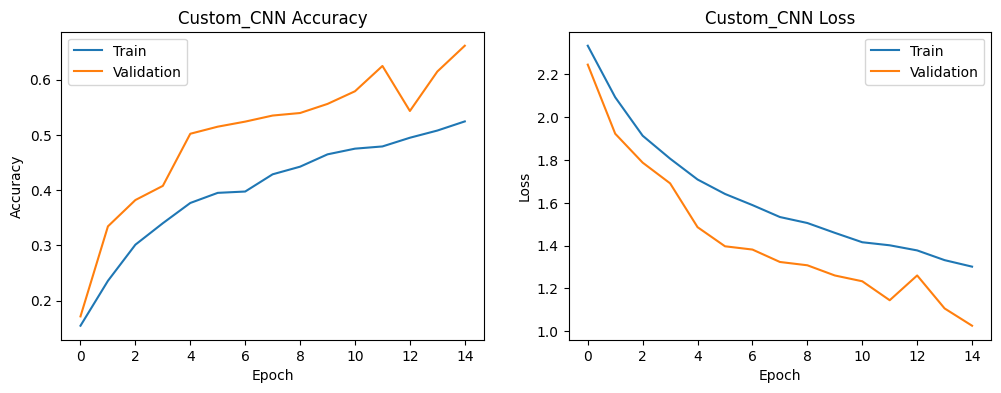

In [37]:
for name, history in custom_cnn_histories.items():
    plot_history(history, name)

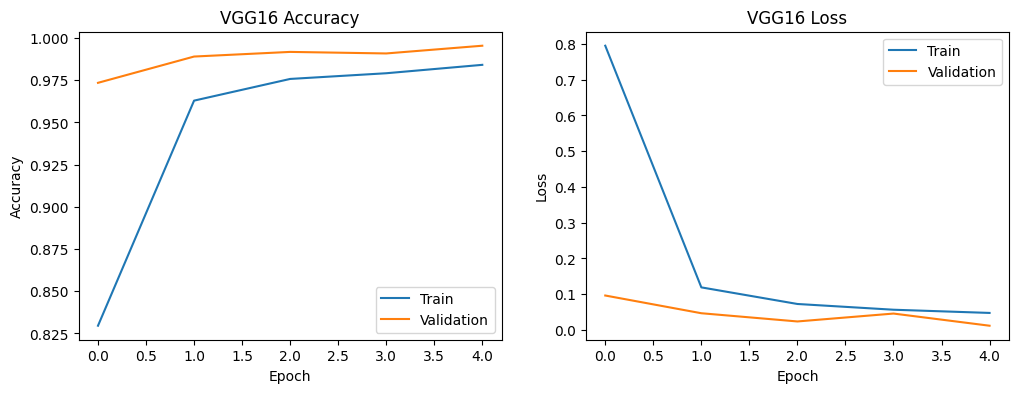

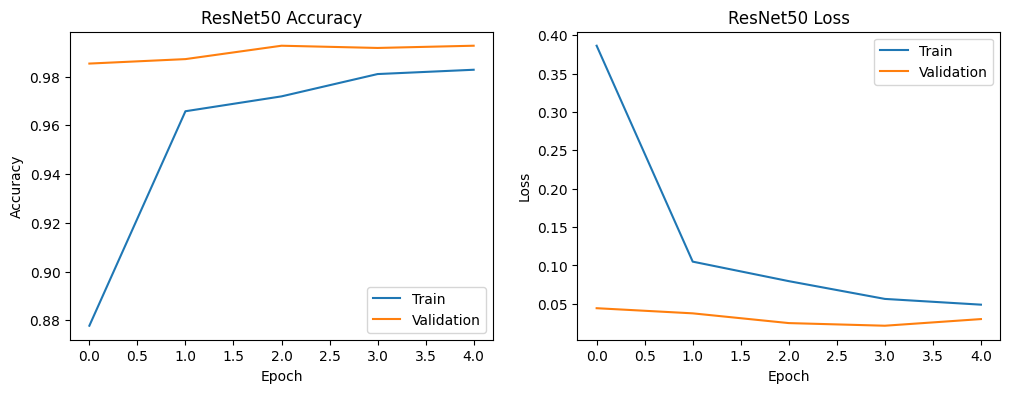

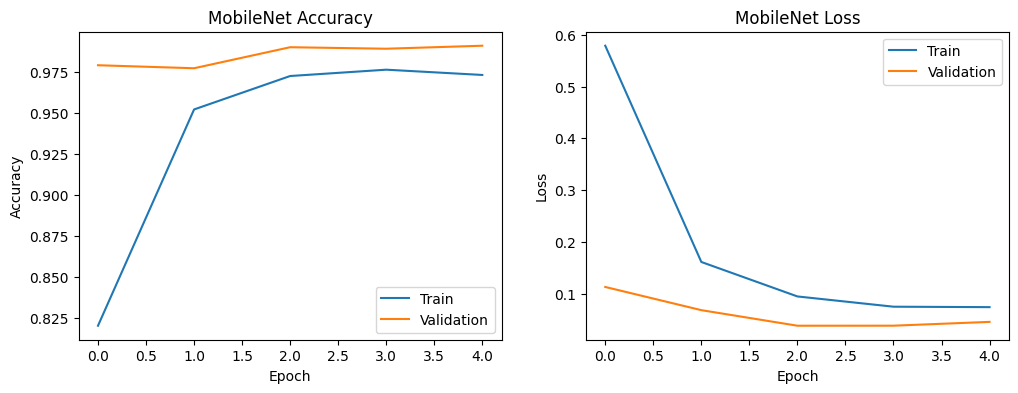

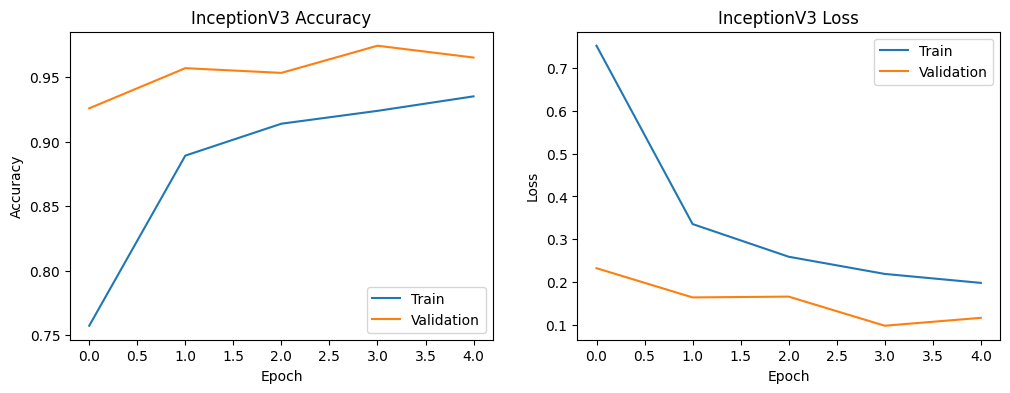

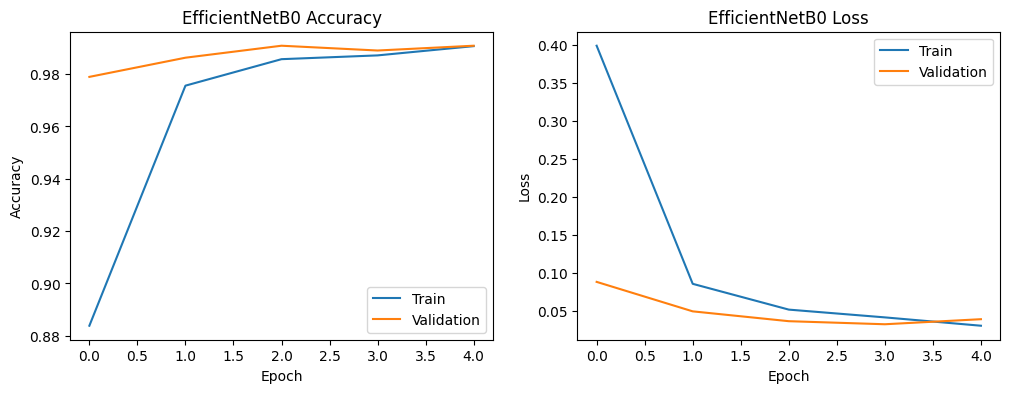

In [38]:
for name, history in pretrained_model_histories.items():
    plot_history(history["transfer_learning"], name)

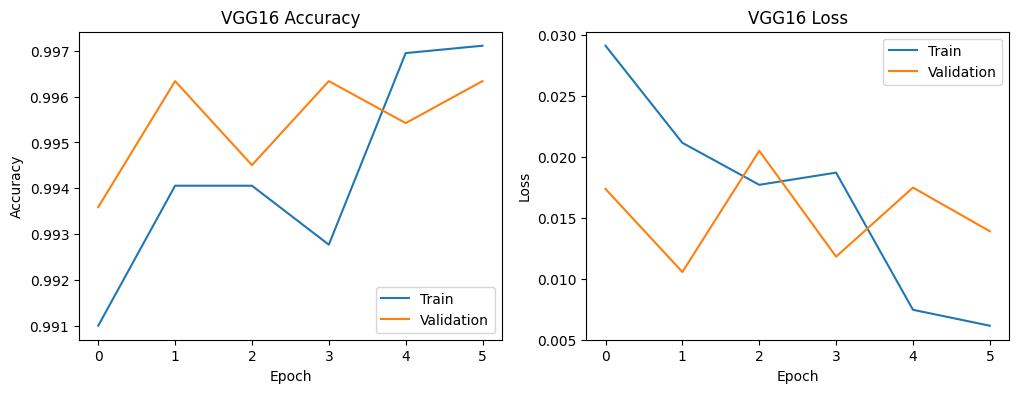

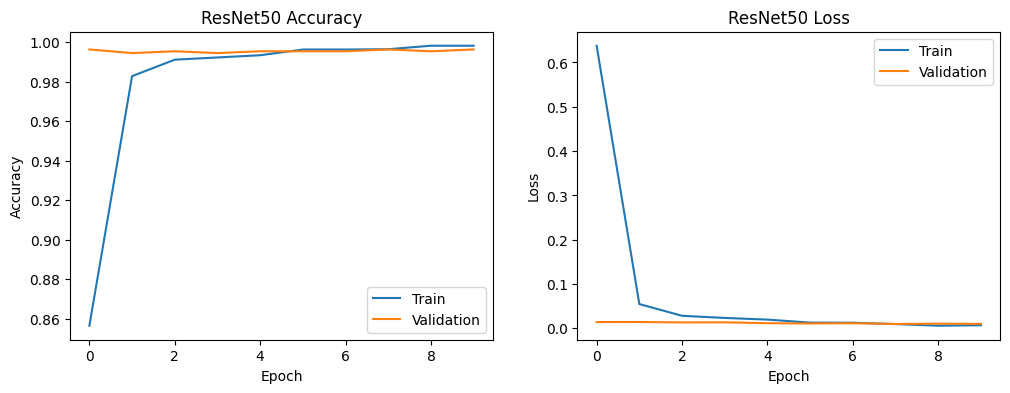

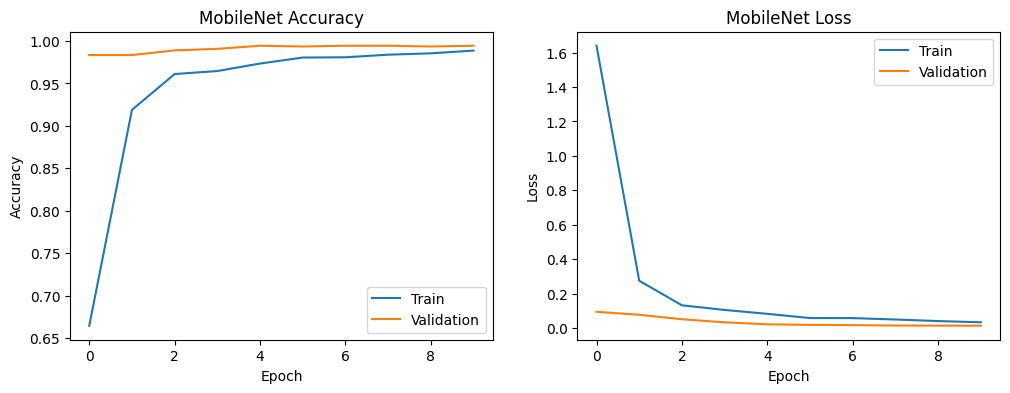

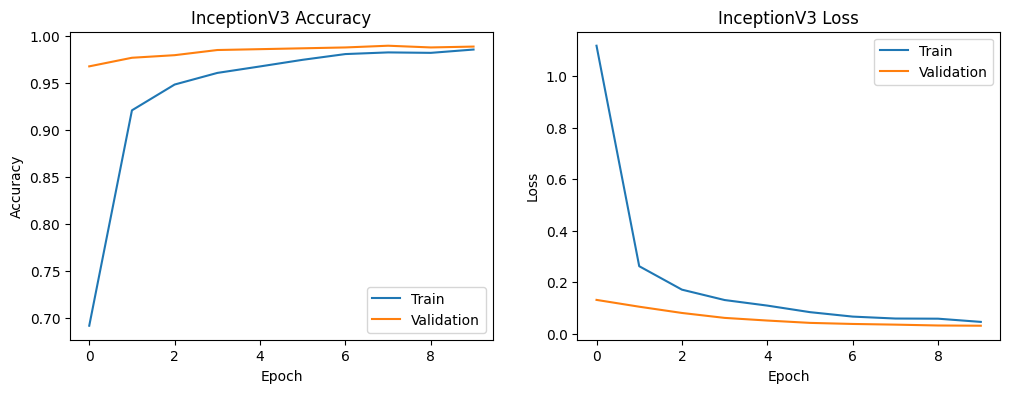

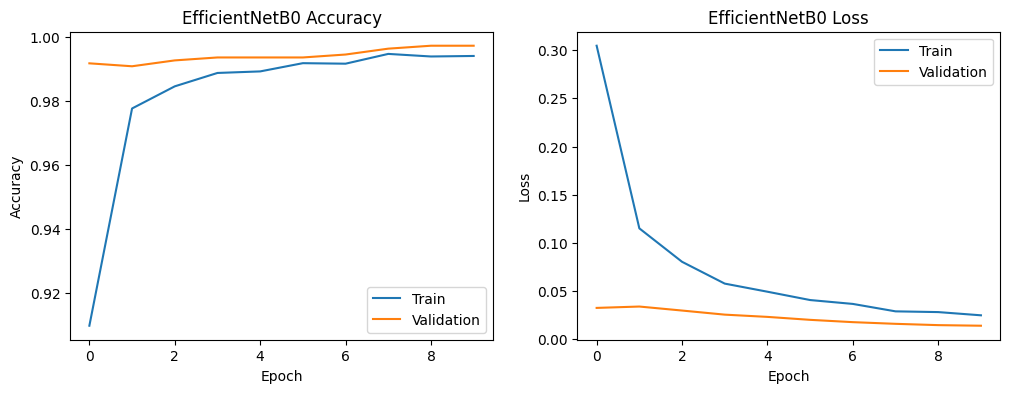

In [39]:
for name, history in pretrained_model_histories.items():
    plot_history(history["fine_tuning"], name)

# EVALUATE ALL MODELS

In [40]:
def evaluate_model(model_path, test_ds, class_names, title):
    model = tf.keras.models.load_model(model_path)

    y_true = np.concatenate([y for _, y in test_ds])
    y_pred = np.argmax(model.predict(test_ds, verbose=0), axis=1)

    print(f"\n{'='*60}")
    print(f" Evaluation: {title}")
    print(f"{'='*60}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

In [41]:
test_custom_pp = prepare_custom_ds(test_ds)

evaluate_model(
    model_path=ARTIFACTS / "CustomCNN.keras",
    test_ds=test_custom_pp,
    class_names=class_names,
    title="Custom CNN"
)


 Evaluation: Custom CNN

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.96      0.95      0.96       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.63      0.97      0.77       298
   fish sea_food gilt_head_bream       0.86      0.56      0.68       305
   fish sea_food hourse_mackerel       0.44      0.08      0.14       286
        fish sea_food red_mullet       0.75      0.66      0.70       291
     fish sea_food red_sea_bream       0.65      0.72      0.68       273
          fish sea_food sea_bass       0.49      0.40      0.44       327
            fish sea_food shrimp       0.54      0.80      0.64       289
fish sea_food striped_red_mullet       0.29      0.37      0.33       293
             fish sea_food trout       0.72      0.84      0.77       292

                        accuracy                           0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
pretrained_names = [
    "VGG16",
    "ResNet50",
    "MobileNet",
    "InceptionV3",
    "EfficientNetB0"
]

for name in pretrained_names:
    test_pp = prepare_ds(test_ds, name)

    evaluate_model(
        model_path=ARTIFACTS / f"{name}.keras",
        test_ds=test_pp,
        class_names=class_names,
        title=name
    )


 Evaluation: VGG16

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       1.00      1.00      1.00       520
                animal fish bass       0.92      0.85      0.88        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      0.99      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       0.99      1.00      0.99       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           1.00   

# Load Saved Best Model (for Streamlit / Reuse)

In [ ]:
best_model = tf.keras.models.load_model(ARTIFACTS / "VGG16.keras")
best_model.save(
    ARTIFACTS / "fish_image_classifier_VGG16_v1.keras",
    include_optimizer=False
)